# Feature analysis

In this notebook, an in-depth univariate and bivariate analysis of the resulting features is presented.

In [1]:
import io
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sagemaker
import boto3

pd.set_option("max_columns", 99)

def read_parquet_s3(bucket, filepath):
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [136]:
#!python -m pip install --upgrade --quiet pandas

In [2]:
# build training set
train = read_parquet_s3("capstone-transaction-data",
                        "processed_data/train_features.parquet")
train_target = read_parquet_s3("capstone-transaction-data",
                               "preprocessed_data/train_target.parquet")
train = train.merge(train_target, on="id", how="left")
train["purchaseamount_90d"].fillna(0, inplace=True)

# build test set
test = read_parquet_s3("capstone-transaction-data",
                       "processed_data/test_features.parquet")
test_target = read_parquet_s3("capstone-transaction-data",
                              "preprocessed_data/test_target.parquet")
test = test.merge(test_target, on="id", how="left")
test["purchaseamount_90d"].fillna(0, inplace=True)

print(train.shape)
print(test.shape)
train.head()

(288081, 34)
(305007, 34)


,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,unique_dates_180d,transactions_count_180d,purchase_amount_sum_180d,avg_transaction_amount_180d,purchasequantity_sum_180d,time_weighted_amount_180d,unique_dates_90d,transactions_count_90d,purchase_amount_sum_90d,avg_transaction_amount_90d,purchasequantity_sum_90d,time_weighted_amount_90d,unique_dates_60d,transactions_count_60d,purchase_amount_sum_60d,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,purchaseamount_90d
0,12262064,120,65.959999,2295.729980,4.114212,1,213,10.778075,0.563380,109.0,524.0,2132.280029,4.069237,609.0,538.865601,54.0,267.0,1055.380005,3.952734,290.0,319.114532,37.0,185.0,749.809998,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,838.989990
1,12277270,93,24.980000,3601.310059,5.789887,2,210,17.149096,0.442857,81.0,539.0,3129.820068,5.806716,623.0,840.181580,38.0,262.0,1507.849976,5.755153,310.0,509.219116,24.0,188.0,1091.979980,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,1505.689941
2,12332190,49,164.899994,1416.559937,5.169927,0,210,6.745523,0.233333,45.0,259.0,1348.000000,5.204633,328.0,347.427277,27.0,153.0,878.700012,5.743137,199.0,250.572433,15.0,107.0,704.510010,6.584206,141.0,210.490936,6.0,15.0,67.959999,4.530667,20.0,42.900917,1084.780029
3,12524696,70,21.990000,1581.670044,3.886167,3,213,7.425681,0.328638,61.0,368.0,1440.270020,3.913777,463.0,347.924866,27.0,170.0,689.890015,4.058177,214.0,195.126587,16.0,103.0,396.540009,3.849903,137.0,127.830322,8.0,57.0,242.279999,4.250526,74.0,88.039108,871.130005
4,12682470,73,36.990002,1578.010010,4.347135,3,213,7.408498,0.342723,63.0,278.0,1268.130005,4.561619,325.0,308.362732,30.0,112.0,546.119995,4.876071,134.0,161.810654,22.0,61.0,304.299988,4.988524,70.0,106.956429,13.0,41.0,196.849991,4.801219,48.0,78.548553,1113.880005


## 1. Target variable


Max train target 15876
Max test target 21908


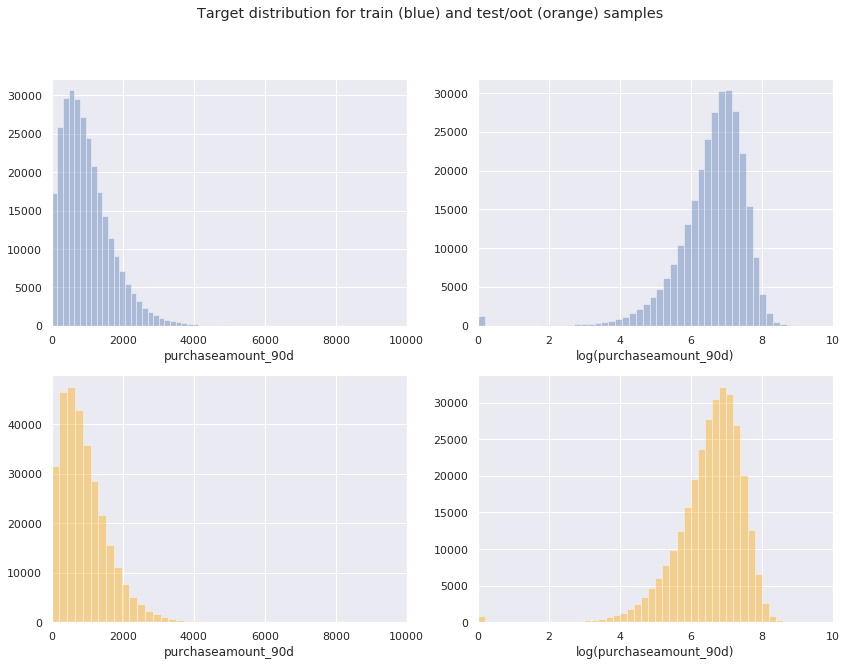

In [3]:
# target distributions (train and test)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle('Target distribution for train (blue) and test/oot (orange) samples')
sns.distplot(train.purchaseamount_90d, ax=axes[0], kde=False, bins=100)
sns.distplot(np.log1p(train.purchaseamount_90d), ax=axes[1], kde=False)
sns.distplot(test.purchaseamount_90d, ax=axes[2], kde=False, color="orange", bins=100)
sns.distplot(np.log1p(test.purchaseamount_90d), ax=axes[3], kde=False, color="orange")
axes[0].set(xlim=(0, 10000), xlabel='purchaseamount_90d')
axes[1].set(xlim=(0, 10), xlabel='log(purchaseamount_90d)')
axes[2].set(xlim=(0, 10000), xlabel='purchaseamount_90d')
axes[3].set(xlim=(0, 10), xlabel='log(purchaseamount_90d)')
print("Max train target", int(train.purchaseamount_90d.max()))
print("Max test target", int(test.purchaseamount_90d.max()))

The target distribution is stable when comparing the train and test samples. However, it might be interesting to apply some transformation like a log to obtain a more gaussian distribution and also to reduce the impact of outliers.

## 2. Missing or infinite values

In [4]:
missing_values = train.isin([np.nan, None]).sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [10]:
inf_values = train.isin([np.inf, -np.inf]).sum()
inf_values[inf_values > 0]

avg_daily_amount        126
unique_dates_to_days    126
dtype: int64

## 3. Recency and churn analysis

The next analysis is related to the time since the last transaction, since this is an important indication of churn. The frequency is also relevant here, since less frequent customers might not have churned, but are still in between two following purchases.

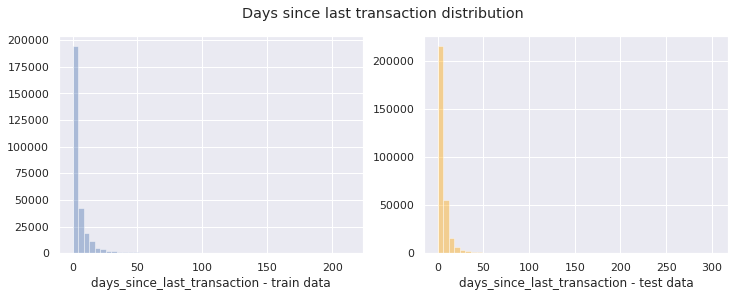

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Days since last transaction distribution')
sns.distplot(train["days_since_last_transaction"], ax=axes[0], kde=False)
sns.distplot(test["days_since_last_transaction"], ax=axes[1], kde=False, color="orange")
_ = axes[0].set(xlabel='days_since_last_transaction - train data')
_ = axes[1].set(xlabel='days_since_last_transaction - test data')

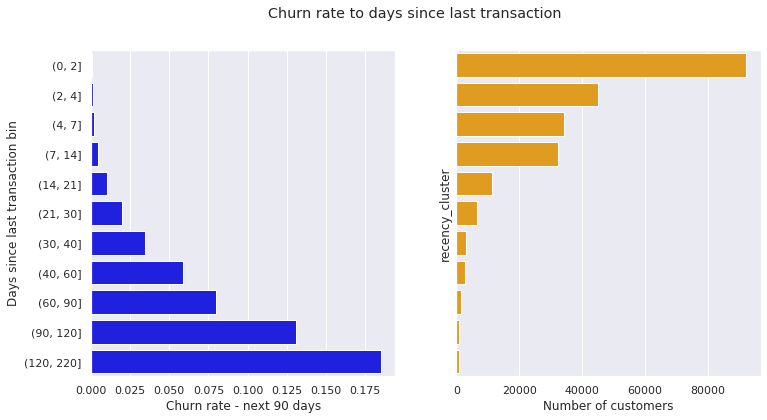

In [74]:
train["churn"] = (train["purchaseamount_90d"] <= 0).astype("int8")
bins = [0, 2, 4, 7, 14, 21, 30, 40, 60, 90, 120, 220]
train["recency_cluster"] = pd.cut(train.days_since_last_transaction,
                                  bins=bins, duplicates="drop")
churn_rate = train.groupby("recency_cluster")["churn"].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Churn rate to days since last transaction')
_ = sns.barplot(y=churn_rate.index.astype("string"), x=churn_rate.values,
                color="blue", ax=axes[0])
sns.countplot(y=train["recency_cluster"], ax=axes[1], color="orange")
_ = axes[0].set(xlabel='Churn rate - next 90 days',
                ylabel="Days since last transaction bin")
_ = axes[1].set(xlabel='Number of customers')

In [33]:
train

,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,unique_dates_180d,transactions_count_180d,purchase_amount_sum_180d,avg_transaction_amount_180d,purchasequantity_sum_180d,time_weighted_amount_180d,unique_dates_90d,transactions_count_90d,purchase_amount_sum_90d,avg_transaction_amount_90d,purchasequantity_sum_90d,time_weighted_amount_90d,unique_dates_60d,transactions_count_60d,purchase_amount_sum_60d,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,purchaseamount_90d,churn
0,12262064,120,65.959999,2295.729980,4.114212,1,213,10.778075,0.563380,109.0,524.0,2132.280029,4.069237,609.0,538.865601,54.0,267.0,1055.380005,3.952734,290.0,319.114532,37.0,185.0,749.809998,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,838.989990,0
1,12277270,93,24.980000,3601.310059,5.789887,2,210,17.149096,0.442857,81.0,539.0,3129.820068,5.806716,623.0,840.181580,38.0,262.0,1507.849976,5.755153,310.0,509.219116,24.0,188.0,1091.979980,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,1505.689941,0
2,12332190,49,164.899994,1416.559937,5.169927,0,210,6.745523,0.233333,45.0,259.0,1348.000000,5.204633,328.0,347.427277,27.0,153.0,878.700012,5.743137,199.0,250.572433,15.0,107.0,704.510010,6.584206,141.0,210.490936,6.0,15.0,67.959999,4.530667,20.0,42.900917,1084.780029,0
3,12524696,70,21.990000,1581.670044,3.886167,3,213,7.425681,0.328638,61.0,368.0,1440.270020,3.913777,463.0,347.924866,27.0,170.0,689.890015,4.058177,214.0,195.126587,16.0,103.0,396.540009,3.849903,137.0,127.830322,8.0,57.0,242.279999,4.250526,74.0,88.039108,871.130005,0
4,12682470,73,36.990002,1578.010010,4.347135,3,213,7.408498,0.342723,63.0,278.0,1268.130005,4.561619,325.0,308.362732,30.0,112.0,546.119995,4.876071,134.0,161.810654,22.0,61.0,304.299988,4.988524,70.0,106.956429,13.0,41.0,196.849991,4.801219,48.0,78.548553,1113.880005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288076,4652467738,11,34.990002,263.790009,10.991250,12,156,1.690962,0.070513,11.0,24.0,263.790009,10.991250,26.0,65.542290,6.0,16.0,173.289993,10.830625,17.0,46.747902,4.0,8.0,63.509998,7.938750,9.0,21.684160,4.0,8.0,63.509998,7.938750,9.0,21.684160,183.740005,0
288077,4652482487,8,19.990000,249.449997,9.238889,9,125,1.995600,0.064000,8.0,27.0,249.449997,9.238889,35.0,64.730011,7.0,21.0,197.580002,9.408571,26.0,54.022327,6.0,20.0,186.589996,9.329500,25.0,51.435532,2.0,7.0,57.959999,8.280000,7.0,18.759434,289.769989,0
288078,4652496809,5,20.000000,102.349998,6.020588,0,154,0.664610,0.032468,5.0,17.0,102.349998,6.020588,24.0,59.825699,2.0,7.0,51.320000,7.331429,10.0,49.465202,2.0,7.0,51.320000,7.331429,10.0,49.465202,2.0,7.0,51.320000,7.331429,10.0,49.465202,192.240005,0
288079,4672069809,100,104.930000,3184.360107,4.975563,4,213,14.950047,0.469484,89.0,558.0,2851.800049,5.110753,834.0,679.921509,37.0,271.0,1453.000000,5.361624,410.0,392.020111,22.0,142.0,720.380005,5.073099,195.0,223.662827,12.0,71.0,394.390015,5.554789,97.0,140.247803,463.329987,0


## 4. Feature distribution

In this section we will be looking at numerical features and checking their distribution and relationship with the target variable. We will also have a look at the stability between the training and test (oot) samples.

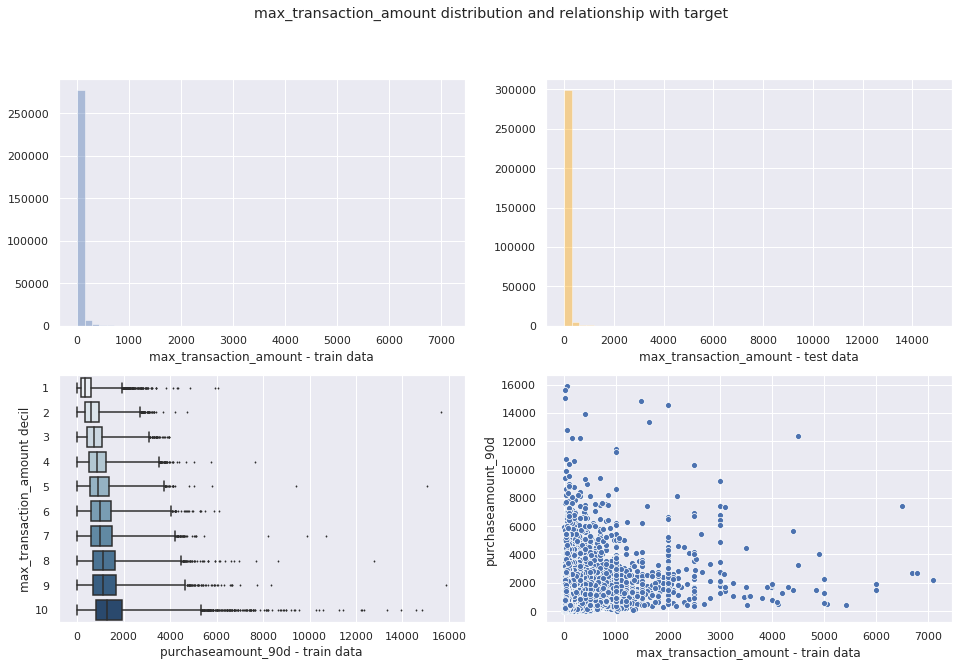

In [11]:
def plot_feature(feature, q=10, num_labels=10):
    x_train = train[~train[feature].isin([np.nan, np.inf])]
    x_test = test[~test[feature].isin([np.nan, np.inf])]
    labels = [str(i+1) for i in range(num_labels)]
    x_train["decil"] = pd.qcut(train[feature], q=q, labels=labels,
                               precision=1, duplicates="drop")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    fig.suptitle('{} distribution and relationship with target'.format(feature))
    sns.distplot(x_train[feature], ax=axes[0], kde=False)
    sns.distplot(x_test[feature], ax=axes[1], kde=False, color="orange")
    sns.boxplot(y="decil", x="purchaseamount_90d", data=x_train, ax=axes[2],
                whis=3, fliersize=1, saturation=0.5, palette="Blues")
    sns.scatterplot(x=feature, y="purchaseamount_90d", ax=axes[3], data=x_train)
    axes[0].set(xlabel='{} - train data'.format(feature))
    axes[1].set(xlabel='{} - test data'.format(feature))
    axes[2].set(xlabel='purchaseamount_90d - train data'.format(feature),
                ylabel="{} decil".format(feature))
    axes[3].set(xlabel='{} - train data'.format(feature))


plot_feature("max_transaction_amount")

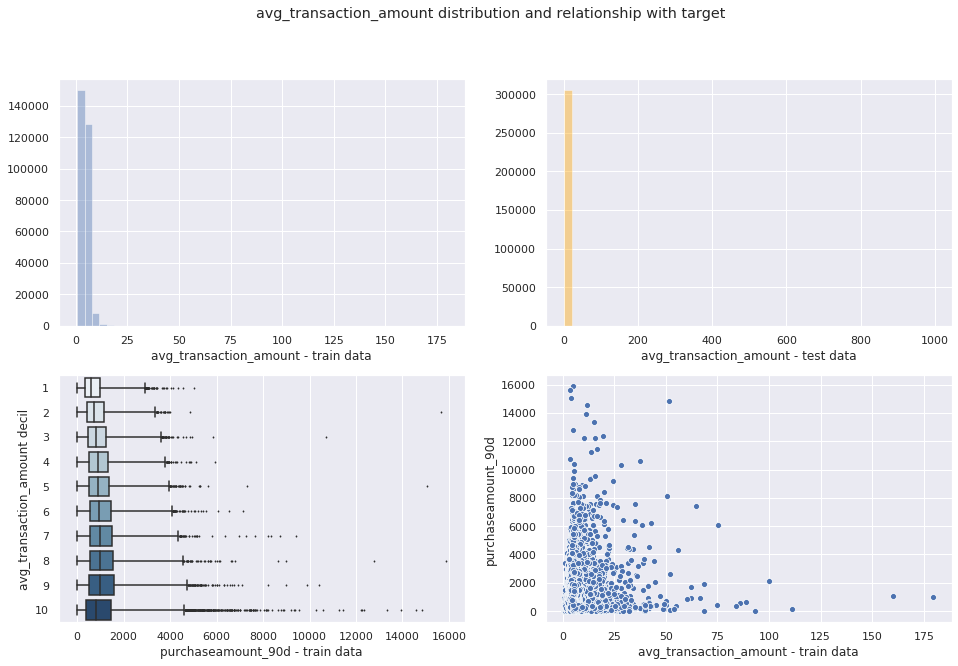

In [12]:
plot_feature("avg_transaction_amount")

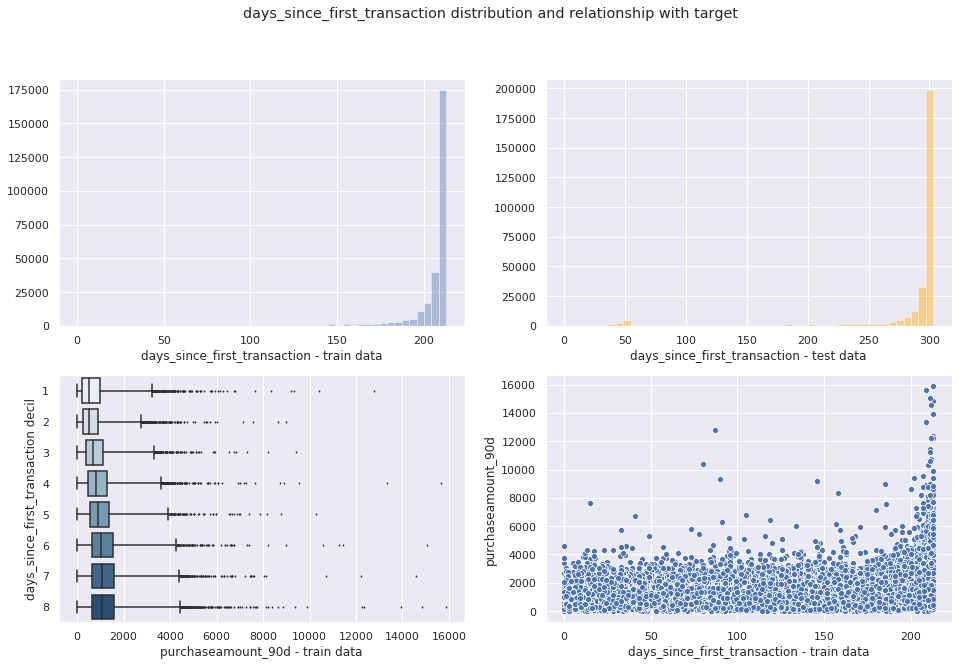

In [22]:
plot_feature("days_since_first_transaction", num_labels=8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


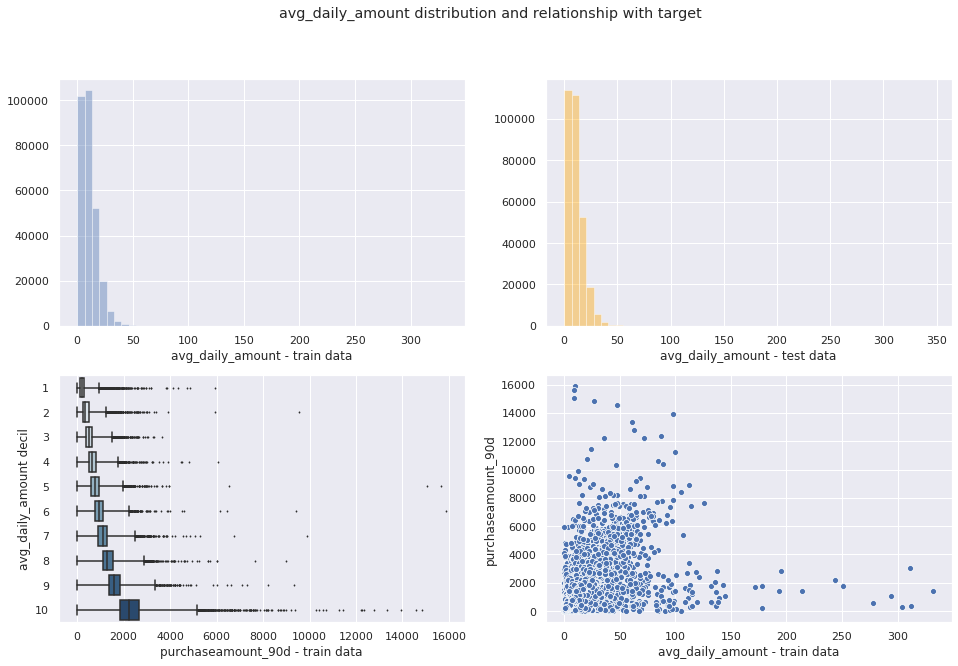

In [24]:
plot_feature("avg_daily_amount", num_labels=10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


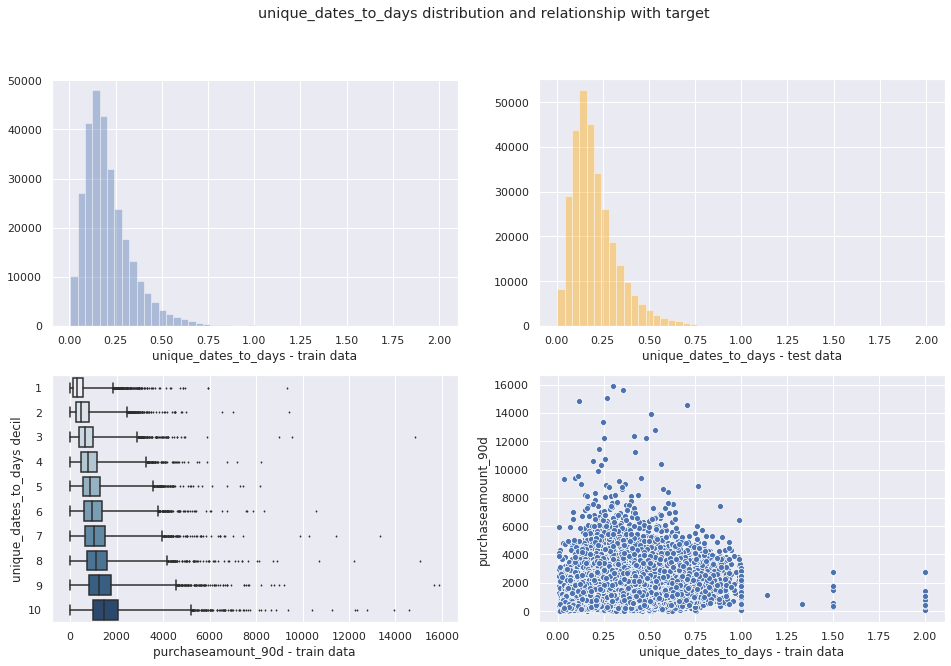

In [25]:
plot_feature("unique_dates_to_days", num_labels=10)